In [1]:
import os
import cv2
import h5py
import keras
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from keras.models import Sequential, load_model
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
size = 256
channels = 1
batch_size = 100

dataset_path = "images/0"
resized_path = "squared_images/"
train_path = "bw_images/"
validate_path = "gray_images/"
test_path = "test/"

models_path = "saved_parameters/"
saved_model = "saved_model.h5"
saved_weights = "saved_weights.h5"

In [3]:
# Create directory
def create_dir(folder_name):
    folder = os.path.join(folder_name)
    if not os.path.exists(folder):
        os.mkdir(folder)
    return folder
                          
def save_path(dir_path, file, appended_name):
    file_base = os.path.basename(file)
    file_name, file_ext = os.path.splitext(file_base)   
    return dir_path + file_name + appended_name + file_ext
            
# Create and save black and white images
def convert_RGB2BW(dataset_path):
    bw_path = create_dir("bw_images/")
    grayscale_path = create_dir("gray_images/")
    for file in os.listdir(dataset_path):
        image = Image.open(os.path.join(dataset_path, file))
        
        # Convert image to grayscale based on Lighting
        grayscale = image.convert('L')
        grayscale = np.asarray(grayscale).copy()
        gray_image = Image.fromarray(grayscale)
        gray_image.save(save_path(grayscale_path, file, "_GR"))
        
        # Turn darker pixels black (0) and lighter pixels white (255)
        grayscale[grayscale < 128] = 0
        grayscale[grayscale >= 128] = 255
        bw_image = Image.fromarray(grayscale)
        bw_image.save(save_path(bw_path, file, "_BW"))
        
# Preprocess images: creates a white image and pastes data into white image
def square_images(dataset_path, size):
    dir_path = create_dir("squared_images/")
    for file in os.listdir(dataset_path):
        image = Image.open(os.path.join(dataset_path, file))
        width, height = image.size
        if(width != height and width != size):
            squared_image = image.resize((size,size), Image.LANCZOS)
            #squared_image.paste(image)
            squared_image.save(save_path(dir_path, file, "_SQ"))
                          

In [32]:
# Load training and validating images into array
def load_data(dir_path):
    data_arr = []
    for image in os.listdir(dir_path):
        img_read = Image.open(os.path.join(dir_path, image))
        data_arr.append(np.asarray(img_read))
    return data_arr

def test_load(dir_path):
    data_arr = []
    for count, image in zip(range(1, 5), os.listdir(dir_path)):
        img_read = Image.open(os.path.join(dir_path, image))
        data_arr.append(np.asarray(img_read))
    return data_arr

# Calculate epoch size to traverse all training data
def epoch_size(dir_path, batch_size):
    counter = 0
    for file in os.listdir(dir_path):
        if os.path.isfile(os.path.join(dir_path, file)):
            counter += 1
    return counter/batch_size

In [ ]:
# Resize Image
square_images(dataset_path, size)

In [ ]:
# Image Preprocessing
convert_RGB2BW(resized_path)

In [33]:
# Load images into arrays
'''
train_arr = load_data(train_path)
validate_arr = load_data(validate_path)
'''
train_arr = test_load(train_path)
validate_arr = test_load(validate_path)

# Convert image array into numpy array
train_np = np.array(train_arr)
validate_np = np.array(validate_arr)

# Normalize
train_np = train_np/255
validate_np = validate_np/255

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


In [22]:
# Check data size, dimensions, and channels
print(train_np.shape)
print(validate_np.shape)

(9, 256, 256)
(9, 256, 256)


3


TypeError: Invalid dimensions for image data

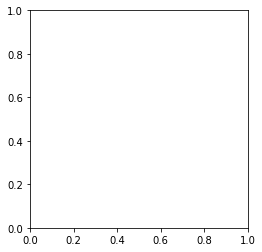

In [28]:
# Removes extra numpy dimension so image can be plotted
x = np.squeeze(train_np)
print(x.ndim)
plt.imshow(x)
plt.show()

In [ ]:
# Autoencoder model
auto = Sequential()
auto.add(Input(shape=(size, size, channels)))

# Encoder - smaller filters, larger feature map
auto.add(Conv2D(16, (3,3), activation="relu", input_shape(size, size, 1)))
auto.add(MaxPooling2D((2,2), padding = "same"))
auto.add(Conv2D(32, (3,3) activation="relu"))
auto.add(MaxPooling2D((2,2), padding = "same"))
auto.add(Conv2D(64, (3,3) activation="relu"))
auto.add(MaxPooling2D((2,2), padding = "same"))
auto.add(Conv2D(128, (3,3) activation="relu"))
auto.add(MaxPooling2D((2,2), padding = "same"))
auto.add(Conv2D(256, (3,3) activation="relu"))
auto.add(MaxPooling2D((2,2), padding = "same"))

# Decoder 
auto.add(UpSampling2D(2,2))
auto.add(Conv2D(256, (3,3), activation='relu', padding='same'))
auto.add(UpSampling2D(2,2))
auto.add(Conv2D(128, (3,3), activation='relu', padding='same'))
auto.add(Conv2D(64, (3,3), activation='relu', padding='same'))
auto.add(UpSampling2D(2,2))
auto.add(Conv2D(32, (3,3), activation='relu', padding='same'))
auto.add(UpSampling2D(2,2))
auto.add(Conv2D(16, (3,3), activation='relu', padding='same'))

auto.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
auto = load_model(saved_model)
#auto = load_weight(saved_weights)

In [ ]:
# fit(training data, label data, ...)
auto.fit(train_np, validate_np, validation_split=0.1, epochs=epoch_size, verbose=1, shuffle=True, 
        steps_per_epoch=step_size(train_path, batch_size),
        callbacks = EarlyStopping(min_delta=0.001, patience=5))

In [ ]:
auto.save(os.path.join(models_path, saved_model))
#auto.save((os.path.join(models_path, saved_weights))

In [ ]:
def get_predicted(test_path):
    predicted_path = create_dir("predicted_images/")
    for image in os.listdir(test_path):
        predicted_gray = auto.predict(image)
        predicted_img = Image.fromarray(predicted_gray)
        predicted_img.save(save_path(predicted_path, file, "_PR"))

In [ ]:
get_predicted(test_path)